# Tugas Case Study 02 Kelompok 5

1. 1906375700	Teguh Saputra
2. 1906377851	Ammar Yazid Daffala
3. 1906375713	Nathanael Andrian Patrick
4. 1906376640	Muhammad Rangga Buwana
5. 1906304263	Mohammad Lanang Syeikha
6. 1906306054	Rizqa Fatika Fajrianti
7. 1906375820	Risfania Nurdinda Sari
8. 1906377864	Nurul Annisa

Berdasarkan data dan instruksi yang telah diberikan, akan dilakukan analisis data dengan metode clustering untuk mendapatkan insight untuk membantu MixITup Ice Cream dalam meningkatkan jangkauan bisnis dan menentukan cara marketing terbaik untuk menarik pelanggan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import euclidean
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform 
from math import isnan
import pytest
import setuptools

In [2]:
### Import The Data ###

df = pd.read_csv('https://raw.githubusercontent.com/Ammardaffala/ADM-Case-02-Clustering/main/Case-Study-02-MixITup%20(1).csv',
                 sep=';')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    200 non-null    int64  
 1   Jenis Kelamin         196 non-null    object 
 2   Umur                  200 non-null    object 
 3   Pendapatan-per-bulan  200 non-null    object 
 4   skor-pengeluaran      200 non-null    int64  
 5   Menikah               188 non-null    object 
 6   Kota                  200 non-null    object 
 7   Promo                 194 non-null    float64
 8   HariFav               200 non-null    object 
 9   FavFlavor             200 non-null    int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 15.8+ KB


## Data Preprocessing

Sebelum melakukan analisis, akan dilakukan data preprocessing terlebih dahulu agar data yang diberikan siap untuk digunakan dalam proses analisis

1. Untuk variabel umur, terdapat data yang tidak sesuai dengan tipe data yang seharusnya, sehingga dilakukan perubahan tipe data pada data tersebut
2. Untuk variabel pendapatan per bulan, akan dihilangkan 'Rp' dan tanda '.' sehingga tipe data pendapatan per bulan dapat diubah menjadi integer

In [3]:
### Bersihkan Kolom "Umur" dan "Pendapatan-per-bulan"

df.loc[df['Umur']=="35'", 'Umur'] = 35
df['Pendapatan-per-bulan'] = [x.strip('Rp') for x in df['Pendapatan-per-bulan']]
df['Pendapatan-per-bulan'] = [x.replace('.','') for x in df['Pendapatan-per-bulan']]

In [4]:
### Bersihkan "Noise" yang terdapat pada Beberapa Kolom yang ada pada data ###

# Data Cleansing
df.replace('-', np.nan,inplace=True)
df.replace(' ', np.nan,inplace=True)

# Pendapatan tidak mungkin 0 tapi bisa membeli
# Nilai 0 merupakan outliers bawah. Kami memutuskan untuk merubahnya menjadi NA
df['Pendapatan-per-bulan'].replace(0, np.nan, inplace=True)

# Terdapat kesalahan terhadap penulisan
df['Kota'].replace('JJakarta','Jakarta', inplace=True)

# Rentang skor-pengeluaran 0-100
df['skor-pengeluaran'].replace(101,100,inplace=True)

# Rentang promo 0-3
df['Promo'].replace(5.0, 3.0, inplace=True)

# Hanya ada 8 varian rasa
df['FavFlavor'].replace(9, 8, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    200 non-null    int64  
 1   Jenis Kelamin         195 non-null    object 
 2   Umur                  200 non-null    object 
 3   Pendapatan-per-bulan  200 non-null    object 
 4   skor-pengeluaran      200 non-null    int64  
 5   Menikah               186 non-null    object 
 6   Kota                  200 non-null    object 
 7   Promo                 194 non-null    float64
 8   HariFav               200 non-null    object 
 9   FavFlavor             200 non-null    int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 15.8+ KB


In [5]:
### Drop semua baris yang mengandung missing values ###

print(df.isna().sum())
print('\n')

df.dropna(inplace=True)

print(df.info())

ID                       0
Jenis Kelamin            5
Umur                     0
Pendapatan-per-bulan     0
skor-pengeluaran         0
Menikah                 14
Kota                     0
Promo                    6
HariFav                  0
FavFlavor                0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    176 non-null    int64  
 1   Jenis Kelamin         176 non-null    object 
 2   Umur                  176 non-null    object 
 3   Pendapatan-per-bulan  176 non-null    object 
 4   skor-pengeluaran      176 non-null    int64  
 5   Menikah               176 non-null    object 
 6   Kota                  176 non-null    object 
 7   Promo                 176 non-null    float64
 8   HariFav               176 non-null    object 
 9   FavFlavor             176 non-null    int64 

Selanjutnya akan dilakukan penggantian tipe data untuk kolom yang belum sesuai. Kolom Jenis Kelamin, Kota, Promo, HariFav, dan FavFlavor diubah menjadi kategorik. Untuk kolom Umur, Pendapatan-per-bulan, dan Menikah akan diubah menjadi integer.

In [6]:
### Ganti Tipe Kolom ###

df['Jenis Kelamin'] = df['Jenis Kelamin'].astype('category')
df['Umur'] = df['Umur'].astype('int64')
df['Pendapatan-per-bulan'] = df['Pendapatan-per-bulan'].astype('int64')
df['Menikah'] = df['Menikah'].astype('category')
df['Kota'] = df['Kota'].astype('category')
df['Promo'] = df['Promo'].astype('category')
df['HariFav'] = df['HariFav'].astype('category')
df['FavFlavor'] = df['FavFlavor'].astype('category')

In [7]:
### Drop kolom ID ###

df.drop(columns=['ID'], inplace=True)

## EDA

In [8]:
df.describe()

,Umur,Pendapatan-per-bulan,skor-pengeluaran
count,176.000000,1.760000e+02,176.000000
mean,37.136364,1.858933e+07,50.448864
std,12.324361,1.058554e+07,26.001048
min,2.000000,0.000000e+00,1.000000
25%,27.000000,1.106557e+07,34.750000
50%,36.000000,1.885246e+07,51.000000
75%,47.000000,2.540984e+07,73.000000
max,60.000000,5.000000e+07,99.000000


In [9]:
df_cat = df.select_dtypes(include = ['category'])
df_cat.head()

,Jenis Kelamin,Menikah,Kota,Promo,HariFav,FavFlavor
0,Wanita,1,Jakarta,1.0,Sabtu,2
1,Wanita,1,Depok,1.0,Minggu,6
2,Pria,1,Jakarta,2.0,Minggu,3
3,Pria,0,Jakarta,1.0,Rabu,7
4,Wanita,1,Jakarta,2.0,Senin,8


In [10]:
df_cat = df.select_dtypes(include = ['category'])
df_cat.head()

,Jenis Kelamin,Menikah,Kota,Promo,HariFav,FavFlavor
0,Wanita,1,Jakarta,1.0,Sabtu,2
1,Wanita,1,Depok,1.0,Minggu,6
2,Pria,1,Jakarta,2.0,Minggu,3
3,Pria,0,Jakarta,1.0,Rabu,7
4,Wanita,1,Jakarta,2.0,Senin,8


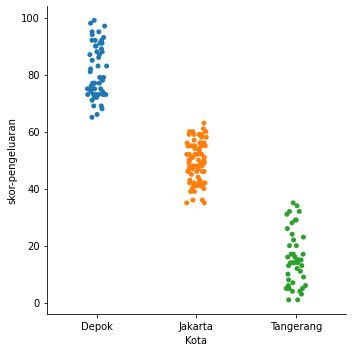

In [11]:
#Akan dilihat kota dengan skor pengeluaran terbesar
p= sns.catplot(x="Kota", y="skor-pengeluaran", data=df)

Dari Category Plot, Kota Depok mengeluarkan skor pengeluaran terbesar dan Kota Tangerang memiliki skor pengeluaran Kota Tangerang

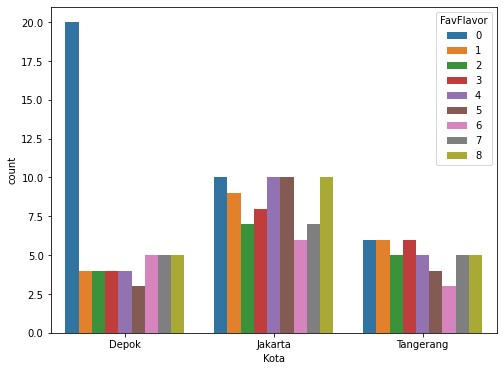

In [12]:
#Akan dicari rasa favorit di tiap kota
plt.figure(figsize=(8,6))
p = sns.countplot(x="Kota", hue="FavFlavor", data=df)

Dari plot di atas, dapat dilihat rasa vanila merupakan rasa paling favorit di Kota Depok. Lalu di Kota Jakarta, rasa paling favorit kostumer adalah vanila, blueberry, bubblegum dan rasa campuran. Lalu rasa paling favorit di Kota Tangerang adalah rasa vanila, stroberi, dan cokelat.

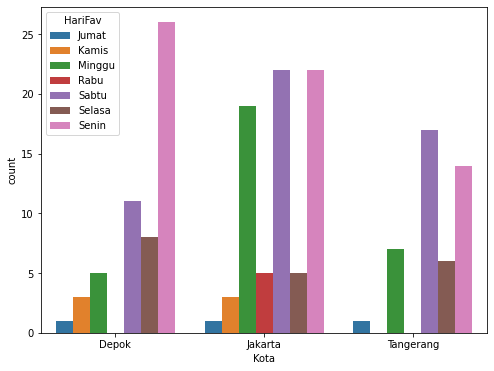

In [33]:
#Akan dicari hari favorit di tiap kota
plt.figure(figsize=(8,6))
p = sns.countplot(x="Kota", hue="HariFav", data=df)

Dilihat dari plot di atas, Kota Depok paling sering dikunjungi pada hari Senin. Lalu Kota Jakarta paling sering dikunjungi di hari Senin dan Sabtu. Dan Kota Tangerang paling sering dikunjungi di hari Sabtu.

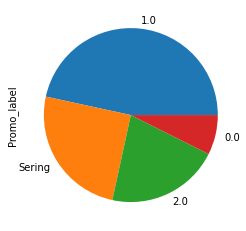

In [34]:
df['Promo_label'] = df["Promo"].replace(0.0, 'Tidak Pernah')
df['Promo_label'] = df["Promo"].replace(1.0, 'Jarang')
df['Promo_label'] = df["Promo"].replace(2.0, 'Sedang')
df['Promo_label'] = df["Promo"].replace(3.0, 'Sering')

plot = df.Promo_label.value_counts().plot(kind='pie')

Dari pie plot di atas, dapat dilihat perbandingan penggunaan promo yang dipakai kostumer.

## Customer Segmentation dengan K-Means Clustering

Akan dilakukan pengelompokkan pelanggan dengan metode K-Means Clustering. Pertama-tama, dilakukan standarisasi data terlebih dahulu untuk menyeragamkan nilai-nilai data agar seluruh data memiliki format yang konsisten dan menjadi standar.

In [13]:
### Standarisasi Data ###

# Memisahkan kolom yang bertipe numerik dan kategorik
df_num = df.select_dtypes(include='int64')
df_cat = df.select_dtypes(include='category')

# Standarisasi semua kolom yang numerik
cluster_scaler = preprocessing.RobustScaler() # robustscaler digunakan untuk menghindari outliers
X_num_scaled = pd.DataFrame(cluster_scaler.fit_transform(df_num),
                             columns=df_num.columns)

# One hot encode kolom kategorik
df_cat = pd.get_dummies(df_cat)

# Gabungkan kembali kedua data tersebut
df_cluster = pd.concat([X_num_scaled.reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)

Selanjutnya akan ditentukan jumlah kluster yang paling optimal dengan Metode Elbow. Banyaknya kluster yang dipilih didasarkan pada letak titik dimana terdapat penurunan yang tajam sebelum titik tersebut dan disusul penurunan yang tidak tajam setelah titik tersebut.

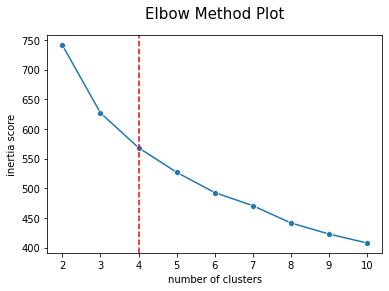

In [14]:
### Menentukan Jumlah Kluster Paling Optimal dengan Elbow Method ###

inertia = []
n_cluster = range(2, 11)

for c in n_cluster:
  km = cluster.KMeans(n_clusters=c, init='k-means++', max_iter=200)
  km.fit(df_cluster)
  inertia.append(km.inertia_)

sns.lineplot(x=n_cluster, y=inertia, marker='o')
plt.axvline(x=4, color='red', linestyle='--')
plt.title('Elbow Method Plot', y=1.05, fontsize=15)
plt.ylabel('inertia score')
plt.xlabel('number of clusters')

plt.show()

Berdasarkan Elbow Plot di atas, banyak kluster yang dipilih adalah sebanyak 4 kluster, karena inertia score setelah kluster ketiga sudah tidak berkurang secara signifikan.

Kemudian akan ditentukan jumlah kluster yang paling optimal dengan Metode Silhouette. Banyaknya kluster yang dipilih didasarkan pada titik dimana titik dimana silhouette score memiliki nilai tertinggi

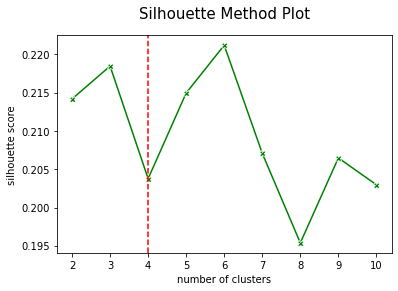

In [36]:
### Menentukan Jumlah Kluster Paling Optimal dengan Silhouette Method ###

sil_score = []
n_cluster = range(2, 11)

for c in n_cluster:
  km = cluster.KMeans(n_clusters=c, init='k-means++', max_iter=200)
  km.fit(df_cluster)
  avg_sil_score = silhouette_score(df_cluster, km.labels_, metric='euclidean')
  sil_score.append(avg_sil_score)

sns.lineplot(x=n_cluster, y=sil_score, marker='X', color='green')
plt.axvline(x=4, color='red', linestyle='--')
plt.title('Silhouette Method Plot', y=1.05, fontsize=15)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')

plt.show()

Berdasarkan Silhouette Plot di atas, banyak kluster yang dipilih adalah sebanyak 4 kluster, karena silhouette score memiliki nilai tertinggi pada kluster keempat.

Selanjutnya, akan dilakukan clustering dengan menggunakan metode K-Means++. Metode ini menginisialisasi centorid secara tidak random, namun dengan cara melihat probabilitas data terbaik untuk menjadi centroid awal. Selain itu, iterasi yang dibutuhkan juga lebih sedikit dibandingkan dengan K-Means biasa.

In [37]:
### Conduct K-Means Clustering ###

km_final = cluster.KMeans(n_clusters=4, init='k-means++', max_iter=200, random_state=699)
km_final.fit(df_cluster)

df['Cluster'] = km_final.labels_

df['Cluster'].value_counts()

0    54
2    44
1    41
3    37
Name: Cluster, dtype: int64

Setelah dilakukan klustering dengan menggunakan metode k-means++ dengan 4 kluster, diperoleh bahwa terdapat 37 pelanggan pada kluster pertama, 41 pelanggan pada kluster kedua, 45 pelanggan pada kluster ketiga, dan 53 pelanggan pada kluster keempat.

Selanjutnya, akan dilakukan evaluasi dari model K-Means yang didapat menggunakan Silhouette Score dan DB Index, dimana semakin Silhouette Score mendekati 1, maka semakin baik model yang digunakan. Sedangkan, semakin rendah DB Index, maka semakin baik model yang digunakan.

In [38]:
### Evaluate The K-Means Model ###

# Using silhouette score
avg_sil = silhouette_score(df_cluster, km_final.labels_, metric='euclidean')
print('Silhouette score: ', round(avg_sil, 2))

# Using DB index
db = davies_bouldin_score(df_cluster, km_final.labels_)
print('DB index: ', round(db, 2))

Silhouette score:  0.2
DB index:  1.8


Selanjutnya, akan dicari median dari masing-masing kluster yang telah didapatkan. Hal ini bertujuan untuk melihat kluster mana yang memiliki skor pengeluaran paling tinggi. 

In [39]:
### Mencari Cluster dengan Skor Pengeluaran Paling Tinggi ###

df.groupby('Cluster')['skor-pengeluaran'].median()

Cluster
0    78.5
1    55.0
2    14.0
3    42.0
Name: skor-pengeluaran, dtype: float64

In [40]:
df_cluster0 = df[df['Cluster']==0]

# Summary variabel numerik pada kluster 0
display(df_cluster0[['Umur', 'Pendapatan-per-bulan']].median())
print('\n')

# Summary variabel kategorik pada kluster 0
display(df_cluster0.select_dtypes(include='category').mode())

Umur                          30.0
Pendapatan-per-bulan    23770491.0
dtype: float64

,Jenis Kelamin,Menikah,Kota,Promo,HariFav,FavFlavor,Promo_label
0,Wanita,1,Depok,1.0,Senin,0,1.0


Berdasarkan hasil algoritma K-Means clustering, didapatkan 4 kluster. disini kami akan berfokus pada cluster 0 yang merupakan cluster dengan skor pengeluaran terbesar dibanding dengan cluster yg lain

Pada cluster 0, kita dapat melihat bahwa ciri-ciri kustomer dengan skor pengeluaran terbesar rata-rata berumur 32 tahun, rata-rata pendapatan perbulan Rp.25.819.672,00, berjenis kelamin Wanita, Telah menikah, jarang menggunakan promo, hari favorit mereka kebanyakan senin, dan rasa favorit mereka vanilla

disini kami menyarankan kepada MixITup ketika ingin scaling bisnis ke kota lain, untuk dapat mencari daerah atau kawasan dengan profil diatas, yaitu kawasan dengan kebanyakan Wanita yang sudah menikah dan dengan rata-rata pendapatan perbulan Rp.25.819.672,00

Tim kami menyarankan untuk pembukaan toko di area perumahan dengan ekonomi menengah keatas, karena dengan profil kustomer diatas kita berhipotesis bahwa kustomer dengan poin pengeluaran terbesar adalah ibu rumah tangga, dengan kisaran umur 32 tahun, dan telah menikah, kita juga berasumsi alasan lain kenapa poin pengeluaran tinggi adalah mereka membelikan es-krim selain untuk diri mereka sendiri juga untuk anak mereka, jadi kita dapat menargetkan pasar kita ke Ibu dan Anak, ini bisa juga dijadikan sebagai bentuk promosi atau marketing.